In [167]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torchvision.transforms.functional as TF
import cv2
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import numpy as np


In [168]:
class MaxPool(nn.Module):
    def __init__(self, pool_size):
        super(MaxPool, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)

    def forward(self, x):
        # print("x shape ", x.shape)
        return self.pool(x)


class Noise(nn.Module):
    def __init__(self, R_scale):
        super(Noise, self).__init__()
        self.mean = 0
        self.stdev = 1  # as defined in the paper

    def forward(self, d_coarse):
        noise = torch.rand_like(d_coarse)*self.stdev + self.mean
        d_noised = d_coarse + noise
        return d_noised


class IntervalThreshold(nn.Module):
    def __init__(self, m, n):
        super(IntervalThreshold, self).__init__()
        self.m = m
        self.n = n

    def forward(self, d_pool):
        threshold = (torch.max(d_pool) - torch.min(d_pool))/min(self.m, self.n)
        return threshold


class ReconGraph(nn.Module):
    def __init__(self, m, n):
        super(ReconGraph, self).__init__()
        self.m = m
        self.n = n

    def forward(self, d_noised, threshold):
        neighbours = set()
        labels = {}

        count = 0
        # print(self.m, self.n)
        for i in range(self.m):
            for j in range(self.n):

                labels[(j, i)] = count  # Labeling each pixel in (x, y) form
                count += 1
                for dy in range(-1, 2):
                    for dx in range(-1, 2):

                        if dx != 0 and dy != 0 and i+dy >= 0 and i+dy < self.m and j+dx >= 0 and j+dx < self.n:
                            if abs(d_noised[0][i+dy][j+dx] - d_noised[0][i][j]) <= threshold:
                                # (x, y) format
                                neighbours.add(((j, i), (j+dx, i+dy)))
        adjacency_matrix = torch.zeros(
            (self.m*self.n, self.m*self.n), dtype=bool)
        # print(adjacency_matrix.shape)

        for val in neighbours:
            N1, N2 = val  # in (x, y) form
            N1_x, N1_y = N1
            N2_x, N2_y = N2

            l1 = labels[(N1_x, N1_y)]
            l2 = labels[(N2_x, N2_y)]

            # Symmetric connections
            adjacency_matrix[l1, l2] = 1
            adjacency_matrix[l2, l1] = 1

        return adjacency_matrix


class GraphDropout(nn.Module):
    def __init__(self, p=0.5) -> None:
        super(GraphDropout, self).__init__()
        self.p = p

    def forward(self, adjacency_matrix):
        if self.train:
            mask = torch.empty_like(adjacency_matrix).bernoulli_(1 - self.p)
            output = adjacency_matrix * mask

        else:
            output = adjacency_matrix

        return output


In [169]:
class ExtractGraph(nn.Module):

    def __init__(self) -> None:
        super(ExtractGraph, self).__init__()

        self.maxpool = MaxPool(pool_size=2)
        self.noise = Noise(R_scale=0.4)  # From paper results
        self.dropout = GraphDropout(p=0.5)

    def forward(self, d_coarse, R_scale):

        # print('d_coarse: ', d_coarse.shape, 'type: ', d_coarse.dtype)
        d_pool = self.maxpool.forward(d_coarse)
        m = d_pool.shape[1]
        n = d_pool.shape[2]
        self.interval_threshold = IntervalThreshold(m, n)
        self.recon_graph = ReconGraph(m, n)

        # print("pooled shape ", d_pool.shape)
        d_noise = self.noise.forward(d_pool)
        threshold = self.interval_threshold.forward(d_pool)
        adjacency_matrix = self.recon_graph.forward(d_noise, threshold)
        adjacency_matrix = self.dropout.forward(adjacency_matrix)

        return adjacency_matrix


In [170]:
class Encoder(nn.Module):

    def __init__(self) -> None:
        super(Encoder, self).__init__()
        encoder = models.resnet.resnet50(
            weights=models.ResNet50_Weights.DEFAULT)
        encoder = nn.Sequential(*list(encoder.children()))[:3]
        self.resnet_encoder = encoder

    def forward(self, x):
        self.resnet_encoder.eval()
        return self.resnet_encoder(x)


In [171]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [172]:
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import DataLoader

preprocessing_transform_2 = transforms.Compose([
    transforms.ToTensor()
])

In [173]:
from gcn_depth_dataloader import GCNDepthDataLoader

# for train set
nyu_dataset_train = GCNDepthDataLoader(mode='train',
                                       image_folder='../dataset/dataset/nyu_depth_v2/official_splits/train/rgb',
                                       depth_folder='../dataset/dataset/nyu_depth_v2/official_splits/train/depth',
                                       transform=preprocessing_transform_2)

nyu_dataset_test = GCNDepthDataLoader(mode='test',
                                      image_folder='../dataset/dataset/nyu_depth_v2/official_splits/test/rgb',
                                      depth_folder='../dataset/dataset/nyu_depth_v2/official_splits/test/depth',
                                      transform=preprocessing_transform_2)

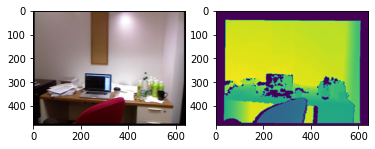

In [174]:
rgb, depth = nyu_dataset_train.__getitem__(1)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(TF.to_pil_image(rgb.squeeze()))
axes[1].imshow(depth.squeeze())

plt.show()

In [178]:
train_dataloader = DataLoader(nyu_dataset_train, batch_size=8, shuffle=True)
print(len(train_dataloader))

# for rgb, depth in train_dataloader:
    # print(rgb.shape, depth.shape)
    
    # fig, axes = plt.subplots(1, 2)
    # axes[0].imshow(TF.to_pil_image(rgb.squeeze()))
    # axes[1].imshow(depth.squeeze())

    # plt.show()
    # break

100


In [179]:
midas_model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", midas_model_type)
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if midas_model_type == "DPT_Large" or midas_model_type == "DPT_Hybrid":
    midas_transform = midas_transforms.dpt_transform
else:
    midas_transform = midas_transforms.small_transform

Using cache found in /Users/adityadandwate/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/adityadandwate/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/adityadandwate/.cache/torch/hub/intel-isl_MiDaS_master


In [180]:
from torch.utils.data import Dataset, DataLoader

class GraphDataLoader(Dataset):
    def __init__(self, dataset, transform=None) -> None:
        super().__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        rgb, true_depth = self.dataset.__getitem__(index)
        features, adj_matrix, true_adj_matrix = self.graph_extract(rgb, true_depth)
        return features, adj_matrix, true_adj_matrix, true_depth

    def graph_extract(self, rgb, true_depth):
        extractor = ExtractGraph()
        encoder = Encoder()

        rgb = rgb.permute(1, 2, 0)*255
        rgb = rgb.numpy()
        # print('rgb shape ', rgb.shape, ' true depth shape ', true_depth.shape)
        rgb = midas_transform(rgb).to(device) # (1, C, H, W)

        # print('rgb shape after midas transform ', rgb.shape)
        with torch.no_grad():
            depth_map = midas(rgb) #(C, H, W) where C = 1
            down_rgb = encoder.forward(rgb)

        # print('midas depth shape: ',depth_map.shape, ' encoded shape: ', down_rgb.shape)
        target_size = down_rgb.shape[2:]
        num_downsampled_channels = down_rgb.shape[1]
        target_size = [x*2 for x in target_size] # Maxpool will downsample by half further
        # print('targetsize: ', target_size)
        resize_transform = transforms.Resize(target_size)
        depth_map = depth_map
        depth_map = resize_transform(depth_map) # Downsample midas output to (192, 256) using bilinear interpolation

        true_depth_map = resize_transform(true_depth)
        true_depth_map = true_depth_map.to(device=device).to(torch.float32)

        # print("true depth shape ", true_depth_map.shape, " depth map shape ", depth_map.shape)
        adjacency_matrix = extractor.forward(depth_map, 0.4)
        true_adjacency_matrix = extractor.forward(true_depth_map, 0.4)
        # print('pred mat shape: ', adjacency_matrix.shape)
        # print('true mat shape: ', true_adjacency_matrix.shape)

        node_features = torch.reshape(down_rgb, (num_downsampled_channels, -1)) #shape will be (64, 120*160)

        return node_features, adjacency_matrix, true_adjacency_matrix

In [181]:
nyu_dataset_processes_train = GraphDataLoader(nyu_dataset_train, transform=preprocessing_transform_2)
nyu_dataset_processes_test = GraphDataLoader(nyu_dataset_test, transform=preprocessing_transform_2)

processed_train_dataloader = DataLoader(nyu_dataset_processes_train, batch_size=8, shuffle=True)
processed_test_dataloader = DataLoader(nyu_dataset_processes_test, batch_size=8, shuffle=True)
print(len(processed_train_dataloader))
print(len(processed_test_dataloader))


100
82


In [182]:
batch = next(iter(processed_train_dataloader))

feature, intermed_adj_matrix, true_adj_matrix, true_depth= batch

In [183]:
print(feature.shape)
print(intermed_adj_matrix.shape)
print(true_adj_matrix.shape)

torch.Size([8, 64, 12288])
torch.Size([8, 12288, 12288])
torch.Size([8, 12288, 12288])


In [184]:
from tqdm import tqdm

def loss_fn(pred_adj_matrix, grnd_adj_matrix, pred_depth, grnd_depth, dice_coefficient=1):

    grad_x = torch.gradient(pred_depth, dim=1)
    grad_y = torch.gradient(pred_depth, dim=0)

    squared_mag = torch.square(grad_x) + torch.square(grad_y)
    avg_squared_mag = torch.mean(squared_mag)

    l_grad = avg_squared_mag

    ############

    smooth = 1e-7   # To avoid division by zero
    intersection = torch.sum(pred_adj_matrix, grnd_adj_matrix)
    union = torch.sum(pred_adj_matrix) + torch.sum(grnd_adj_matrix)

    dice_score = (2.0*intersection + smooth)/(union + smooth)
    l_dice = 1.0 - dice_score

    ###########

    log_yi = torch.log(grnd_depth)
    log_yii = torch.log(pred_depth)

    d_i = log_yi - log_yii

    num_pix = d_i.numel()

    l_si = torch.sum(d_i**2)/num_pix + (torch.sum(d_i)**2)/num_pix

    final_loss = l_grad + dice_coefficient*l_dice + l_si
    return final_loss


In [210]:
from torch_geometric.data import Data as pyg_Data
from torch_geometric.data import Batch as pyg_Batch


def convert_to_edgeindex(matrix):

    batch_size, num_nodes, _ = matrix.size()
    edge_indices = []
    num_nodes = [num_nodes for i in range(batch_size)]

    for i in range(batch_size):
        adj = matrix[i]
        adj_coo = adj.to_sparse().coalesce()
        edge_index = adj_coo.indices()
        edge_indices.append(edge_index)
    
    graph_data = [pyg_Data(edge_index=e, num_nodes=n) for e, n in zip(edge_indices, num_nodes)]
    g_batch = pyg_Batch.from_data_list(graph_data)
    batch_edge_index = g_batch.edge_index
    print(batch_edge_index.shape)
    return batch_edge_index


In [211]:
from tqdm import tqdm

class GNNModel(nn.Module):

    def __init__(self, n_features) -> None:
        super(GNNModel, self).__init__()
        self.gcn1 = pyg_nn.GCNConv(n_features, 128)
        self.gcn2 = pyg_nn.GCNConv(128, 256)
        self.gcn3 = pyg_nn.GCNConv(256, 32)
        self.gcn4 = pyg_nn.GCNConv(32, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        x = F.relu(self.gcn3(x, edge_index))

        H = x
        H = torch.mm(H, H.T)
        pred_mat = torch.sigmoid(H)

        x = F.relu(self.gcn4(x, edge_index))

        return x, pred_mat

    def trainer(self, train_loader, test_loader, num_epochs, lr):
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr)

        for epoch in tqdm(range(num_epochs)):
            optimizer.zero_grad()
            running_loss = 0.0
            num_samples = 0

            for batch in train_loader:
                
                features, intermed_adj_matrix, true_adj_matrix, true_depth = batch
                intermed_edge_index = convert_to_edgeindex(intermed_adj_matrix)

                pred_depth, pred_mat = self.forward(feature, intermed_edge_index)

                loss = loss_fn(
                    pred_adj_matrix=pred_mat,
                    grnd_adj_matrix=true_adj_matrix,
                    pred_depth=pred_depth,
                    grnd_depth=true_depth
                )

                running_loss += loss.item()*feature.size(0)
                num_samples += features.size(0)

                loss.backward()
                optimizer.step()

            avg_train_loss = running_loss/num_samples

            print(f"train_loss: {avg_train_loss}")

            self.eval()
            with torch.no_grad():
                test_loss = 0.0
                num_test_samples = 0
                for test_batch in test_loader:
                    test_features, test_intermed_adj_matrix, test_true_adj_matrix, test_true_depth = test_batch
                    test_intermed_edge_index = convert_to_edgeindex(test_intermed_adj_matrix)

                    test_pred_depth, test_pred_math = self.forward(test_features, test_intermed_edge_index)

                    test_loss = loss.item()*test_features.size(0)
                    num_test_samples += test_features.size(0)

                avg_test_loss = test_loss/num_test_samples
                print(f"Test Loss: {avg_test_loss}")
                      

In [212]:
num_of_features = 12288
model = GNNModel(num_of_features)

model.trainer(processed_train_dataloader, processed_test_dataloader, 100, 0.0001)

  0%|          | 0/100 [00:46<?, ?it/s]

torch.Size([2, 118547])


RuntimeError: index 157 is out of bounds for dimension 0 with size 64